In [1]:
# === Install Packages ===
!pip install torch gym

import gym
from gym import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import time
import copy
import imageio
import io
from collections import deque
from IPython.display import clear_output

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

In [2]:
# === Define the Environment ===
class ColorTilesEnv(gym.Env):
    def __init__(self, size=4, target_scores=None, inks=None, player_start=None, gamma=0.99):
        super().__init__()
        self.size = size
        self.board_size = size + 2  # include sentinels
        self.target_scores = target_scores
        self.inks = inks
        self.player_start = player_start
        self.gamma = gamma
        self.action_space = spaces.Discrete(4)  # 0:up,1:right,2:down,3:left
        self.observation_space = spaces.Box(0, 33, shape=(self.board_size,self.board_size), dtype=np.float32)
        self.reset()

    def reset(self):
        self.data = np.zeros((self.board_size,self.board_size),dtype=int)
        for y in range(self.board_size):
            for x in range(self.board_size):
                if x==0 or x==self.size+1 or y==0 or y==self.size+1:
                    self.data[y][x] = 6 # sentinels
        for (y,x), v in self.inks.items():
            self.data[y][x] = v
        self.px, self.py = self.player_start
        self.player_color = 0
        self.prev_color = 0
        self.step_count = 0
        self.color_scores = {'red':0,'blue':0,'green':0}

        # save 3 recent actions
        self.action_history = deque(maxlen=4)

        return self._get_state()

    def _get_state(self):
        # return normalized info
        return np.copy(self.data) / 33.0

    # Potential Function
    def _potential(self):
        remaining = 0
        for y in range(1, self.size+1):
            for x in range(1, self.size+1):
                if self.data[y][x] == 0:
                    remaining += 1
        # The fewer tiles remaining, the higher the potential
        return -remaining / (self.size * self.size)

    def step(self, action):
        old_potential = self._potential()

        directions = [(0,-1),(1,0),(0,1),(-1,0)]
        dx, dy = directions[action]
        nx, ny = self.px + dx, self.py + dy
        cell = self.data[ny][nx]
        reward = 0
        done = False

        self.prev_color = self.player_color

        if cell == 11: self.player_color = 1
        elif cell == 22: self.player_color = 2
        elif cell == 33: self.player_color = 3

        # cannot move toward a wall or the other color
        if cell == 6 or (cell > 0 and cell not in (11,22,33) and cell != self.player_color):
            return None # ignore invalid move

        # punish invalid moves
        self.action_history.append(action)
        if len(self.action_history) >= 3:
            a1, a2, a3 = list(self.action_history)[-3:]
            opposite = {0:2, 1:3, 2:0, 3:1}
            if a1 == a3 and a2 == opposite[a1]:
                reward -= 4  # penalty

        color_name = {1:'red',2:'blue',3:'green'}.get(self.player_color)
        if self.player_color > 0:
            if cell != self.player_color:
                self.data[ny][nx] = self.player_color
                reward += 1 # fill a tile
                self.color_scores[color_name] += 1
                if self.color_scores[color_name] == self.target_scores[color_name]:
                    reward += 2 # achieve a target_score
            else:
                reward -= 2  # move toward the same color tile

        # get an ink after achieving a target_score
        if (self.prev_color != 0 and self.prev_color != self.player_color):
            prev_color_name = {1:'red',2:'blue',3:'green'}.get(self.prev_color)
            if self.color_scores[prev_color_name] == self.target_scores[prev_color_name] and self.prev_color != self.player_color:
                reward += 5

        # movement
        self.px, self.py = nx, ny
        self.step_count += 1

        # avoid infinite loops
        if self.step_count >= 200:
            done = True

        # judgement
        if self._all_tiles_colored():
            reward += 20  # Game Clear bonus
            done = True
        elif not self._can_fill_more() or not self._is_color_enough() or \
              self.color_scores['red'] > self.target_scores['red'] or \
              self.color_scores['blue'] > self.target_scores['blue'] or \
              self.color_scores['green'] > self.target_scores['green']:
            reward -= 5  # Game Over
            done = True

        # Potential Shaping
        new_potential = self._potential()
        shaping_reward = self.gamma * new_potential - old_potential
        reward += shaping_reward

        return self._get_state(), reward, done, {}

    def _all_tiles_colored(self):
        for y in range(1,self.size+1):
            for x in range(1,self.size+1):
                if self.data[y][x] in (0, 11, 22, 33):
                    return False
        return True

    def _can_fill_more(self):
        directions = [(0,-1),(1,0),(0,1),(-1,0)]
        for y in range(1,self.size+1):
            for x in range(1,self.size+1):
                if self.data[y][x] != self.player_color:
                    continue
                for dx, dy in directions:
                    nx, ny = x+dx, y+dy
                    if self.data[ny][nx] in (0,11,22,33):
                        return True
        return False

    def _is_color_enough(self):
        if self.color_scores['red'] >= 1 and self.color_scores['red'] < self.target_scores['red'] and self.player_color != 1:
            return False
        if self.color_scores['blue'] >= 1 and self.color_scores['blue'] < self.target_scores['blue'] and self.player_color != 2:
            return False
        if self.color_scores['green'] >= 1 and self.color_scores['green'] < self.target_scores['green'] and self.player_color != 3:
            return False
        return True


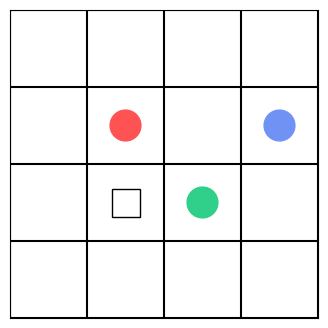

Target Score: (Red: 10, Blue: 2, Green: 4)


In [3]:
# === Draw Initial Board ===
def draw_board(data, px, py, save_fig=False):
    if not save_fig:
        clear_output(wait=True)

    fig, ax = plt.subplots(figsize=(SIZE, SIZE))
    ax.set_xlim(0, SIZE)
    ax.set_ylim(0, SIZE)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")

    # Grid
    for x in range(SIZE + 1):
        ax.plot([x, x], [0, SIZE], color="black")
    for y in range(SIZE + 1):
        ax.plot([0, SIZE], [y, y], color="black")

    # Each Tile
    for y in range(1, SIZE+1):
        for x in range(1, SIZE+1):
            val = data[y][x]
            if val == 1 or val == 11:
                color = "#ff5252"  # red
            elif val == 2 or val == 22:
                color = "#7192f5"  # blue
            elif val == 3 or val == 33:
                color = "#30cf8a"  # green
            else:
                color = "white"
            if val in (1, 2, 3): # filled
                ax.add_patch(plt.Rectangle((x-1, SIZE-y), 1, 1, color=color))
            elif val in (11, 22, 33): # inks
                ax.add_patch(plt.Circle((x-0.5, SIZE-y+0.5), 0.2, color=color))

    # Player
    ax.plot([px-0.5], [SIZE-py+0.5], marker="s", color='black', markerfacecolor="none", markersize=20)

    if save_fig:
        return fig # for gif
    else:
        plt.show() # animation


# === Define the Board ===
SIZE = 4

target_scores = {
    'red': 10,
    'blue': 2,
    'green': 4
}

inks = {
    (2, 2): 11,  # red
    (2, 4): 22,  # blue
    (3, 3): 33   # green
}

player_start = (2, 3)

env = ColorTilesEnv(
    size=SIZE,
    inks=inks,
    target_scores=target_scores,
    player_start=player_start
)
state = env.reset()

# Draw
draw_board(env.data, env.px, env.py)
print(f"Target Score: (Red: {target_scores['red']}, Blue: {target_scores['blue']}, Green: {target_scores['green']})")

In [4]:
def remove_redundant_moves(transitions=None, action_history=None, state_history=None, px=None, py=None):
    directions = [(0,-1),(1,0),(0,1),(-1,0)]
    position_history = [(px, py)] # player pos
    i = 0

    if transitions is not None:
        while i < len(transitions)-1:
            s, a, r, s_next, done = transitions[i]
            dx, dy = directions[a]
            px += dx
            py += dy
            position_history.append((px, py))

            # search backward for the same pos
            for j in range(len(position_history) - 2, -1, -1):
                if position_history[j] == (px, py) and np.array_equal(transitions[j][0], s_next):
                      del transitions[j:i+1]
                      del position_history[j:i+1]
                      i = j-1
                      break
            i += 1

        return transitions

    elif action_history is not None and state_history is not None:
        while i < len(action_history)-1:
            dx, dy = directions[action_history[i]]
            px += dx
            py += dy
            position_history.append((px, py))

            for j in range(len(position_history) - 2, -1, -1):
                if position_history[j] == (px, py) and np.array_equal(state_history[j], state_history[i+1]):
                      del action_history[j:i+1]
                      del state_history[j:i+1]
                      del position_history[j:i+1]
                      i = j-1
                      break
            i += 1

        return action_history

# === Success Experience Buffer ===
class SuccessBuffer:
    def __init__(self, capacity=100):
        self.buffer = deque(maxlen=capacity)

    def push(self, episode_transitions):
        filtered = []
        for (s, a, r, s_next, done) in episode_transitions:
            if not np.array_equal(s, s_next):
                filtered.append((s, a, r, s_next, done))
        cleaned = remove_redundant_moves(transitions=filtered, px=env.px, py=env.py)
        if filtered:
            self.buffer.append(cleaned)

    def sample(self, batch_size):
        if not self.buffer:
            return []
        # choose randomly from the success buffer
        episode = random.choice(self.buffer)
        if len(episode) < batch_size:
            return episode
        else:
            return random.sample(episode, batch_size)

    def __len__(self):
        return len(self.buffer)


In [5]:
# === Define a DQN Network ===
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        h, w = input_shape
        n_input = h * w

        self.net = nn.Sequential(
            nn.Flatten(), # (H, W) -> (H*W)
            nn.Linear(n_input, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_actions)
        )

    def forward(self, x):
        if len(x.shape) == 2: # (H, W)
            x = x.unsqueeze(0) # batch dimension
        return self.net(x)

# === Prioritized Experience Replay ===
class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.7):
        self.capacity = capacity
        self.alpha = alpha
        self.memory = []
        self.priorities = []
        self.pos = 0

    def push(self, transition, td_error=1.0):
        p = (abs(td_error) + 1e-5) ** self.alpha
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
            self.priorities.append(p)
        else:
            self.memory[self.pos] = transition
            self.priorities[self.pos] = p
            self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.memory) == 0:
            raise ValueError("Replay memory is empty")

        probs = np.array(self.priorities, dtype=np.float32)
        probs_sum = probs.sum()
        if probs_sum == 0:
            probs = np.ones_like(probs) / len(probs)
        else:
            probs = probs / probs_sum

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[i] for i in indices]

        weights = (len(self.memory) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, torch.tensor(weights, dtype=torch.float32)


    def update_priorities(self, indices, td_errors):
        for idx, td in zip(indices, td_errors):
            self.priorities[idx] = (abs(td) + 1e-5) ** self.alpha

    def __len__(self):
        return len(self.memory)

# === DQN Agent ===
class DQNAgent:
    def __init__(self, env, lr=1e-3, gamma=0.99, epsilon=1.0, eps_min=0.01, eps_decay=0.998):
        self.success_buffer = SuccessBuffer(capacity=100)
        self.env = env
        self.n_actions = env.action_space.n
        self.state_shape = env.reset().shape
        self.memory = PrioritizedReplayMemory(5000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_decay = eps_decay

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(self.state_shape, self.n_actions).to(self.device)
        self.target_net = DQN(self.state_shape, self.n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

    # ε-greedy
    def select_action(self, state):
        state = np.array(state, dtype=np.float32) / 33.0  # normalize
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)
            q_values = self.policy_net(state_tensor)
            return int(torch.argmax(q_values).item())

    def store_transition(self, state, action, reward, next_state, done):
        reward = max(-10.0, min(10.0, reward)) # reward clipping
        self.memory.push((state, action, reward, next_state, done))

    def train_step(self, batch_size=64, beta=0.4, episode_num=0):
        if len(self.memory) < batch_size:
            return

        # combine sucessful samples
        if episode_num >= 200 and len(self.success_buffer) > 0:
            success_samples = self.success_buffer.sample(int(batch_size * 0.3))
            normal_samples, indices, weights = self.memory.sample(int(batch_size * 0.7), beta)
            transitions = success_samples + normal_samples
            weights = torch.tensor(np.concatenate([np.ones(len(success_samples)), weights.numpy()]), dtype=torch.float32).unsqueeze(1).to(self.device)
        else:
            transitions, indices, weights = self.memory.sample(batch_size, beta)

        states, actions, rewards, next_states, dones = zip(*transitions)

        states = torch.tensor(np.array(states) / 33.0, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(np.array(next_states) / 33.0, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        weights = weights.unsqueeze(1).to(self.device)

        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1)[0].detach().unsqueeze(1)
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        td_errors = (target_q_values - q_values).detach().cpu().numpy().flatten()
        self.memory.update_priorities(indices, td_errors)

        loss = (weights * (q_values - target_q_values).pow(2)).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# === Training Loop ===
agent = DQNAgent(env)
num_episodes = 300
best_total_reward = -float("inf")
best_count = float("inf")
best_history = None

for episode in range(num_episodes):
    episode_transitions = []
    state = env.reset()
    total_reward = 0
    done = False
    agent.epsilon = max(agent.eps_min, agent.epsilon * agent.eps_decay)
    state_history = []
    action_history = []

    while not done:
        action = agent.select_action(state)
        result = env.step(action)
        if result is None:
            continue # ignore invalid moves
        state_history.append(state.copy())
        action_history.append(action)
        next_state, reward, done, _ = result
        agent.store_transition(state, action, reward, next_state, done)
        agent.train_step(episode_num=episode)
        episode_transitions.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

    if env._all_tiles_colored():  # Game Clear
        agent.success_buffer.push(episode_transitions)
        action_count = len(remove_redundant_moves(action_history=copy.deepcopy(action_history), state_history=copy.deepcopy(state_history), px=env.px, py=env.py))
        print(f"Success at Episode {episode+1}: steps={action_count}")

        # save the best episode
        if best_history is None or action_count < best_count:
            best_count = action_count
            best_history = (copy.deepcopy(state_history), copy.deepcopy(action_history))

    agent.update_target()

    if (episode+1) % 50 == 0:
        print(f"Episode {episode+1}: Epsilon={agent.epsilon:.3f}")

    if episode == num_episodes-1:
        print(f"Total Success: {len(agent.success_buffer)}")


Success at Episode 16: steps=27


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode 50: Epsilon=0.905
Success at Episode 61: steps=26
Episode 100: Epsilon=0.819
Episode 150: Epsilon=0.741
Success at Episode 162: steps=16
Episode 200: Epsilon=0.670
Episode 250: Epsilon=0.606
Success at Episode 261: steps=23
Success at Episode 282: steps=34
Episode 300: Epsilon=0.548
Total Success: 5


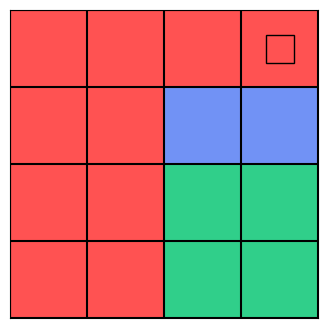

Replay finished.
Steps played: 16, total_reward: 52.881
Final scores: {'red': 10, 'blue': 2, 'green': 4}
Replay saved as best_replay.gif


In [6]:
def replay_best_episode(action_history, state_history, env, delay, gif_path="replay.gif"):
    if env is None:
        raise ValueError("env must be provided")

    state = env.reset()
    total_reward = 0
    step = 0
    frames = []

    action_history = remove_redundant_moves(action_history=action_history, state_history=state_history, px=env.px, py=env.py)

    for action in action_history:
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        step += 1

        # animation
        draw_board(env.data, env.px, env.py)
        scores = {
            'red': int(np.sum(env.data == 1)),
            'blue': int(np.sum(env.data == 2)),
            'green': int(np.sum(env.data == 3))
        }

        # create gif
        fig = draw_board(env.data, env.px, env.py, save_fig=True)
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
        buf.seek(0)
        image = imageio.v3.imread(buf)
        frames.append(image)
        buf.close()
        plt.close(fig)

        time.sleep(delay)

        if done:
            break

    print("Replay finished.")
    print(f"Steps played: {step}, total_reward: {total_reward:.3f}")
    print("Final scores:", scores)

    if frames:
        imageio.mimsave(gif_path, frames, duration=delay*1000)
        print(f"Replay saved as {gif_path}")

    return env.data, env.px, env.py, env.player_color, total_reward

# === Animate and Save the Most Successful Episode ===
if best_history is None:
    print("There were no sucessful episodes.")
else:
    state_history = best_history[0].copy()
    action_history = best_history[1].copy()
    data, px, py, player_color, total_reward = replay_best_episode(
        action_history,
        state_history,
        env=env,
        delay=0.3,
        gif_path="best_replay.gif"
    )
